## Executive Summary

The solution is basically a lightgbm regression model optimize with tweedie regression to handle the spike at 0 and the post prediction of the test is aggregated using sum of the prediction across the test set.

Features used: train, test, dates, store id and holiday features.

Train and test data are joined with dates and store id.

Is_holiday feature is created using holiday feature.

The number of transaction feature is dropped.

The model is built using Ligthgbm with 5 Kfold cross validation and the prediction test set is aggregated across various the ID.

np.log1p is taken to transform the prediction.

**What work**

1. Using tweedie regression objectives

2. Post process the test set prediction using Sum

**What did not work**

1. Groupby aggregate features

2. One hot encoding of the categoricla data.

Author: **Nasirudeen Adeleye Raheem**

In [13]:
print('pandas_version ' + pd.__version__)
print('scikit_learn_version ' + sklearn.__version__)
print('lightgbm_version ' +lgb.__version__)

pandas_version 1.3.4
scikit_learn_version 0.24.2
lightgbm_version 3.3.2


#### Importing the neccessary libariries

In [6]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
import time
import sklearn
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold

In [14]:
## Machine learning model
from lightgbm import LGBMRegressor

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('stores.csv')
holiday = pd.read_csv('holidays.csv')
dates = pd.read_csv('dates.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [16]:
submission = pd.read_csv('SampleSubmission.csv')

In [17]:
print(train.shape)
print(test.shape)
print(store.shape)
print(holiday.shape)
print(dates.shape)
print(sub.shape)

(2248884, 6)
(99792, 4)
(54, 4)
(281, 2)
(1320, 15)
(14256, 2)


In [18]:
train.head()

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,365,store_1,category_24,0.0,0,0.0
1,365,store_1,category_21,0.0,0,0.0
2,365,store_1,category_32,0.0,0,0.0
3,365,store_1,category_18,0.0,0,0.0
4,365,store_1,category_26,0.0,0,0.0


In [19]:
test.head()

,date,store_id,category_id,onpromotion
0,1627,store_1,category_24,0
1,1627,store_1,category_21,0
2,1627,store_1,category_32,0
3,1627,store_1,category_18,16
4,1627,store_1,category_26,0


In [20]:
test.head()

,date,store_id,category_id,onpromotion
0,1627,store_1,category_24,0
1,1627,store_1,category_21,0
2,1627,store_1,category_32,0
3,1627,store_1,category_18,16
4,1627,store_1,category_26,0


In [21]:
dates.head()

,date,year,month,dayofmonth,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,year_weekofyear
0,365,1,1,1,2,1,1,1,True,False,True,False,True,False,101
1,366,1,1,2,3,2,1,1,False,False,False,False,False,False,101
2,367,1,1,3,4,3,1,1,False,False,False,False,False,False,101
3,368,1,1,4,5,4,1,1,False,False,False,False,False,False,101
4,369,1,1,5,6,5,1,1,False,False,False,False,False,False,101


In [22]:
holiday.head()

,date,type
0,1,0
1,5,4
2,12,4
3,42,0
4,43,0


In [23]:
store.head()

,store_id,city,type,cluster
0,store_1,0,0,0
1,store_2,0,0,0
2,store_3,0,0,1
3,store_4,0,0,2
4,store_5,1,0,3


In [24]:
sub.head()

,ID,target
0,year_week_425_store_1_category_0,0
1,year_week_426_store_1_category_0,0
2,year_week_427_store_1_category_0,1
3,year_week_428_store_1_category_0,3
4,year_week_429_store_1_category_0,2


#### Target feature distribution

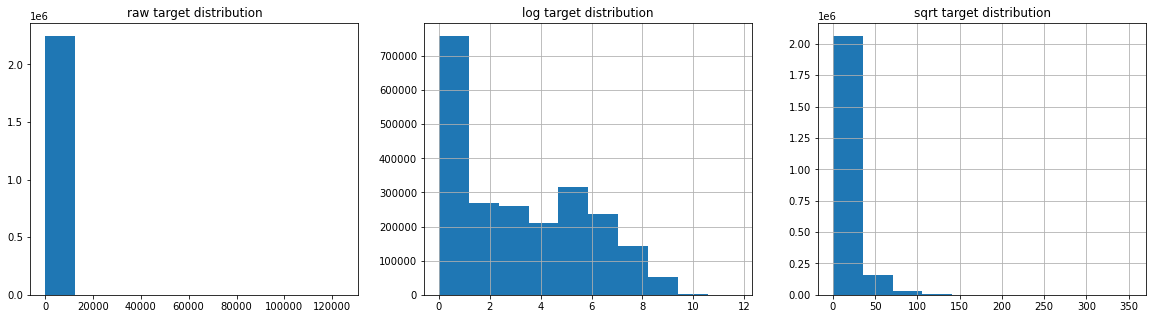

In [53]:
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 3, 1) 
plt.hist(data = train, x = 'target');

plt.title('raw target distribution')
plt.subplot(1, 3, 2)
np.log1p(train['target']).hist();

plt.title('log target distribution')
plt.subplot(1, 3, 3)
np.sqrt(train['target']).hist();
plt.title('sqrt target distribution');

In [40]:
train['target'].describe().round(3)

count    2248884.000
mean         393.265
std         1174.938
min            0.000
25%            0.000
50%           15.000
75%          223.000
max       124717.000
Name: target, dtype: float64

In [42]:
print(train[train['target'] == 0.0].shape[0]/len(train) * 100)

26.53854089406123


We observe 26.5% of the target values are 0.0.

#### Dealing with test and sample submission file

In [25]:
## train merge dates
train = train.merge(dates, on='date')

In [26]:
## test merge date
test = test.merge(dates, on='date')

In [21]:
train['yw'] = 'year_week'

In [22]:
test['yw'] = 'year_week'

In [23]:
train['ID'] = train['yw']+'_'+train['year_weekofyear'].astype(str)+'_'+train['store_id']+'_'+train['category_id']

In [24]:
test['ID'] = test['yw']+'_'+test['year_weekofyear'].astype(str)+'_'+test['store_id']+'_'+test['category_id']

### Feature engineering

In [27]:
train['is_holiday'] = train['date'].isin(holiday['date'].unique())
test['is_holiday'] = test['date'].isin(holiday['date'].unique())

### Merging store data to the original dataset.

In [28]:
train= train.merge(store, on=['store_id'])
test= test.merge(store, on=['store_id'])

### Data Transformation

In [29]:
train['store_id'] = train['store_id'].map(lambda x:x.split('_')[1]).astype(int)
train['category_id'] = train['category_id'].map(lambda x:x.split('_')[1]).astype(int)
test['store_id'] = test['store_id'].map(lambda x:x.split('_')[1]).astype(int)
test['category_id'] = test['category_id'].map(lambda x:x.split('_')[1]).astype(int)

### Machine Learning model

In [30]:
train_f = train.drop(['yw', 'ID','nbr_of_transactions'], axis=1) # training features
test_f = test.drop(['yw', 'ID'], axis=1) # testing features

In [31]:
print(train_f.shape)
print(test_f.shape)

(2248884, 23)
(99792, 22)


In [32]:
## The machine learning dependent and independent features
X = train_f.drop('target', axis=1)
y = train_f['target']

In [97]:
params = {
        "objective" : "tweedie",
    
        "metric" : "rmse",
        "learning_rate" : 0.09,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.6,
        'verbosity': 1,
       'num_iterations' : 3000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


In [98]:
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=5, shuffle=True, random_state=1)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test_f)
    y_pred_totcb.append(p)

C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current v

C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current v

C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current v

C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current v

C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\THIS PC\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.75. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current v

In [99]:
np.mean(np.log1p(errcb))

5.283841823223315

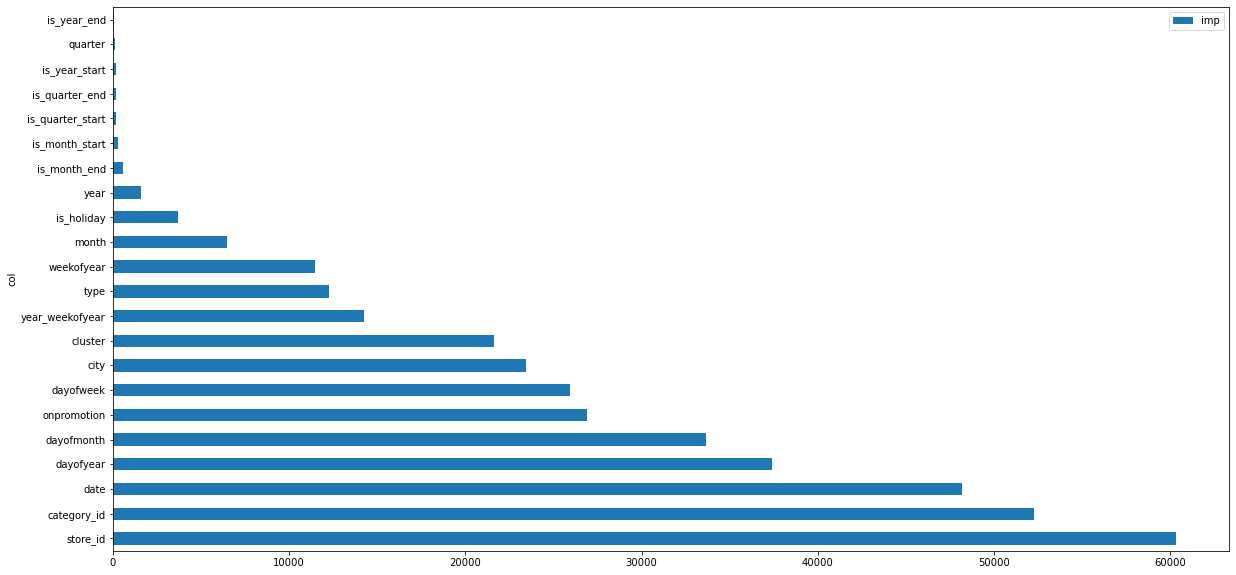

In [100]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [101]:
np.mean(y_pred_totcb, 0)

array([3.88790504e+00, 5.08526735e-03, 2.28684410e+00, ...,
       1.86584321e+03, 3.42203336e+01, 1.96571928e+01])

In [102]:
len(np.mean(y_pred_totcb, 0))

99792

### post preprocess the prediction for the test set

In [103]:
test['target'] = np.mean(y_pred_totcb, 0)

In [104]:
sub = test[['ID', 'target']]

In [105]:
sub.head()

,ID,target
0,year_week_425_store_1_category_24,3.887905
1,year_week_425_store_1_category_21,0.005085
2,year_week_425_store_1_category_32,2.286844
3,year_week_425_store_1_category_18,2273.203248
4,year_week_425_store_1_category_26,0.398729


#### Aggregate the prediction across each ID by their total.

In [106]:
subt = sub.groupby('ID')['target'].sum().reset_index()

In [107]:
prediction = submission.merge(subt, on='ID').rename(columns={'target_y':'target'}).drop('target_x', axis=1)

#### transforming the prediction

In [108]:
prediction['target'] = np.log1p(abs(prediction['target']))

In [110]:
prediction.to_csv('base_lb8.csv', index=False)

## References

1. https://www.youtube.com/playlist?list=PL98nY_tJQXZmT9ZB59T0lsx0ZzzLrYdX4

2. https://www.kaggle.com/code/konradb/ts-4-sales-and-demand-forecasting/notebook

## Appreciation

My sincere appreciation to **Abhishek Thakur** & **KONRAD BANACHEWICZ**